source: https://programminghistorian.org/en/lessons/introduction-to-stylometry-with-python#calculating-feature-averages-and-standard-deviations

## Bibliotheken einlesen

In [53]:
from google.colab import drive
import os
from collections import Counter
import matplotlib.pyplot as plt
import nltk
import math

#nltk.download('punkt')
%matplotlib inline

In [54]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
os.chdir('/content/drive/MyDrive/Colab Notebooks')

## Daten einlesen

In [56]:
def text_to_string(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

In [57]:
file_paths = {
    'Hitler': 'datasets/MeinK/stalag_edition/CUT_Mein Kampf Stalag Edition _djvu.txt',
    'Trump': 'datasets/my_trump/00_cleaned_files/all_files.txt',
    'Biden': 'datasets/my_biden/00_cleaned_files/all_files.txt',
    'Bush': 'datasets/my_bush/all_files.txt',
    'Obama': 'datasets/my_obama/all_files.txt'
}

strings_by_author = {author: text_to_string(path) for author, path in file_paths.items()}

print(strings_by_author['Hitler'][:100])


AUTHOR’S PREFACE 


On April Ist, 1924, I began to serve my sentence of detention in the 
Fortress o


## Token-Length-Verteilungen (nach Mendenhall’s Characteristic Curves of Composition)

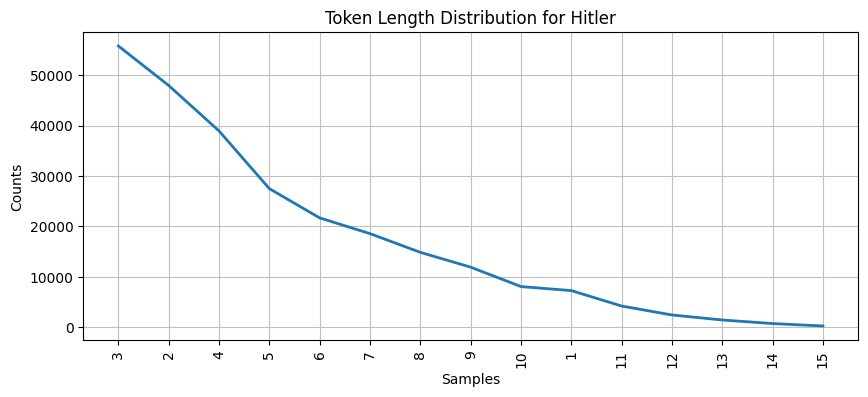

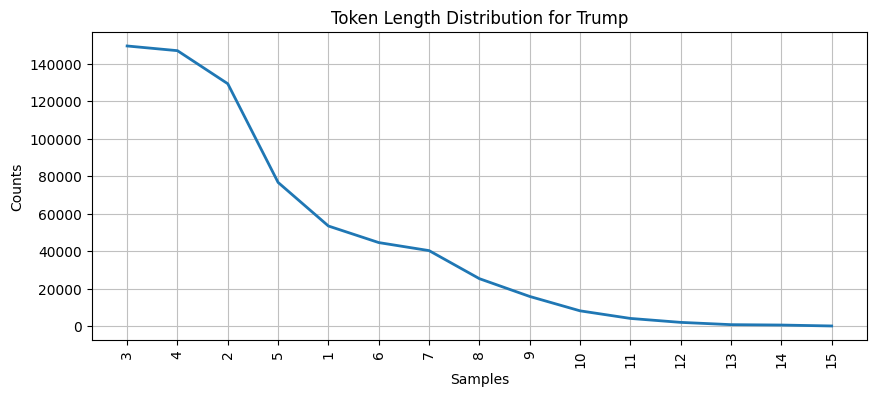

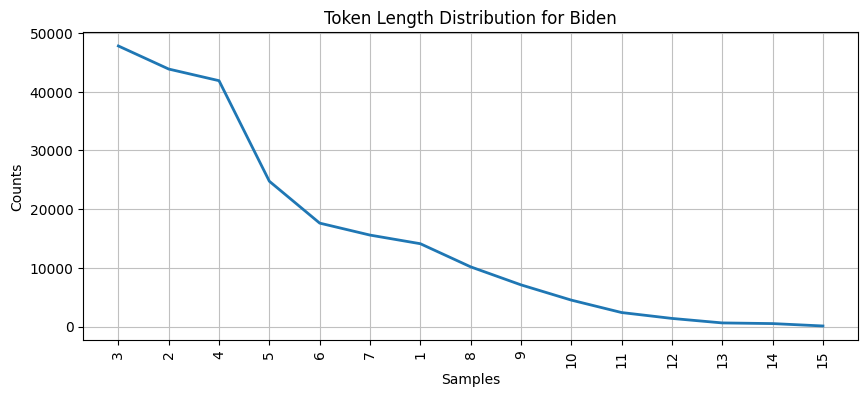

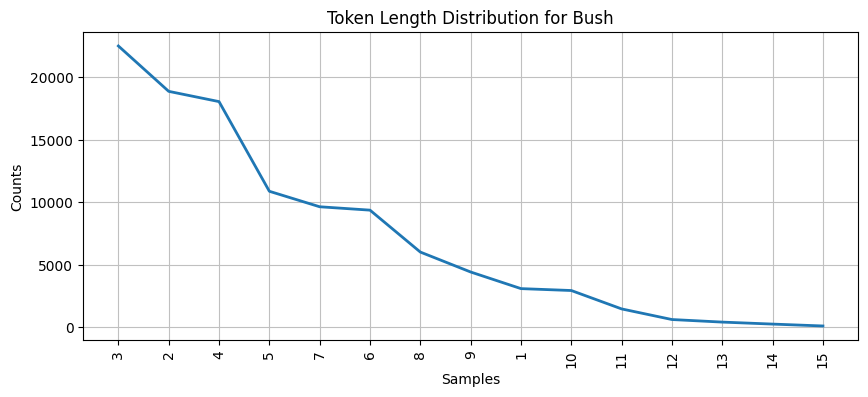

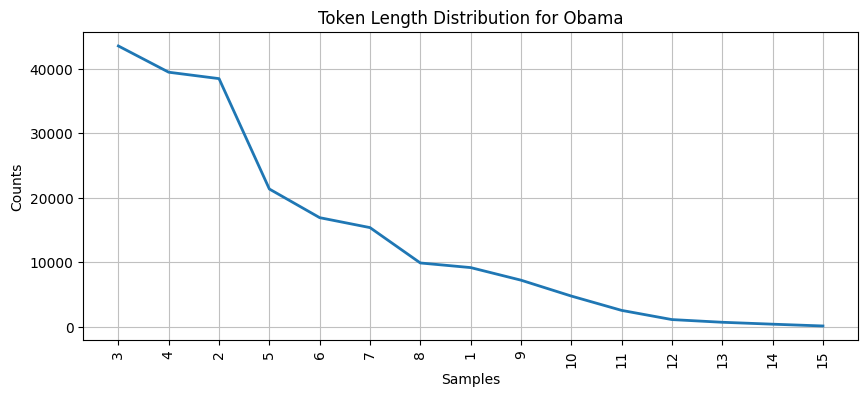

In [58]:
authors = ("Hitler", "Trump", "Biden", "Bush", "Obama")

# Lade Texte und transformiere sie in Tokens
politicians_by_author_tokens = {}
politicians_by_author_length_distributions = {}

for author in authors:
    tokens = nltk.word_tokenize(strings_by_author[author])

    # Filtere die Satzzeichen heraus
    politicians_by_author_tokens[author] = [token for token in tokens if any(c.isalpha() for c in token)]

    # Erstelle eine Verteilung der Tokenlängen
    token_lengths = [len(token) for token in politicians_by_author_tokens[author]]
    politicians_by_author_length_distributions[author] = nltk.FreqDist(token_lengths)

    # Plotte die Verteilung
    plt.figure(figsize=(10, 4))
    politicians_by_author_length_distributions[author].plot(15, title=f'Token Length Distribution for {author}')
    plt.show()

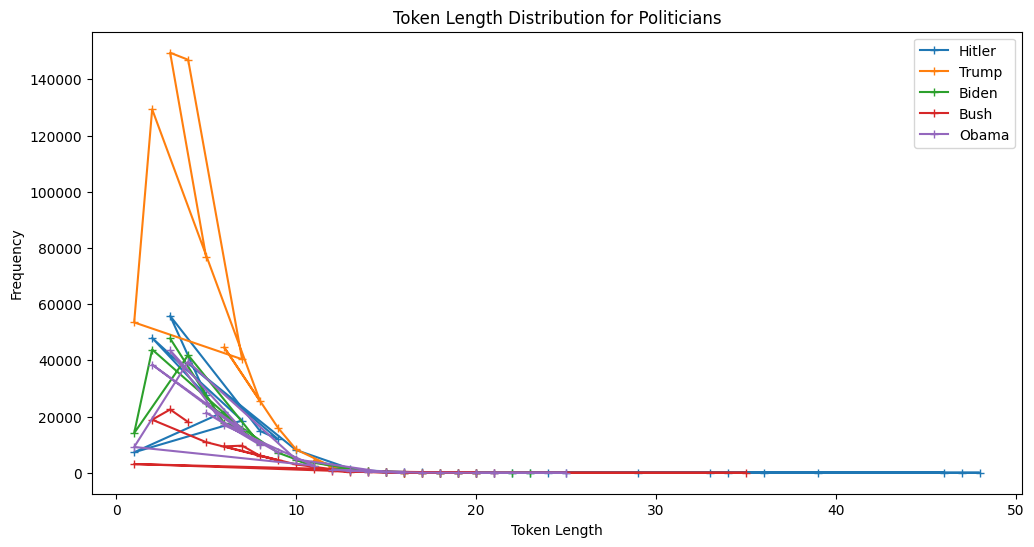

In [59]:
plt.figure(figsize=(12, 6))

for author in authors:
    freq_dist = politicians_by_author_length_distributions[author]
    lengths, frequencies = zip(*freq_dist.items())
    plt.plot(lengths, frequencies, label=author, linestyle='-', marker='+') # Mit Label und Stiloptionen für Unterscheidung

plt.title('Token Length Distribution for Politicians')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()


## Chi-Squared-Statistik berechnen (nach Kilgariff’s Chi-Squared Methode)

Die Chi-Quadrat-Statistik ist ein Maß dafür, wie stark die beobachteten Häufigkeiten von den erwarteten Häufigkeiten abweichen. Bei der Interpretation der Chi-Quadrat-Statistik sind folgende Punkte zu beachten:

Größenordnung des Chi-Quadrat-Werts:

- Ein hoher Chi-Quadrat-Wert deutet darauf hin, dass die beobachteten Häufigkeiten signifikant von den erwarteten Häufigkeiten abweichen. Dies könnte bedeuten, dass die Texte der beiden Autoren (Kandidaten und Disputed) unterschiedlich sind.
- Ein niedriger Chi-Quadrat-Wert deutet darauf hin, dass die beobachteten Häufigkeiten nahe an den erwarteten Häufigkeiten liegen. Dies könnte bedeuten, dass die Texte der beiden Autoren ähnlich sind.

Vergleich zwischen Kandidaten:

- Wenn der Chi-Quadrat-Wert für einen Kandidaten signifikant niedriger ist als für den anderen, könnte dies darauf hinweisen, dass der "Disputed"-Text diesem Kandidaten ähnlicher ist.

Kontext und Freiheitsgrade:

- Die Interpretation des Chi-Quadrat-Werts sollte auch den Kontext und die Freiheitsgrade berücksichtigen. In diesem Fall basiert die Chi-Quadrat-Berechnung auf den 500 häufigsten Wörtern. Die Freiheitsgrade (degrees of freedom) sind in der Regel die Anzahl der Kategorien minus eins.
- Bei einer großen Anzahl von Kategorien (wie hier 500 Wörter) können selbst kleine Abweichungen zu einem hohen Chi-Quadrat-Wert führen. Daher sollte man auch auf die Verteilung der Chi-Quadrat-Werte achten.

Statistische Signifikanz:

- Um festzustellen, ob der Chi-Quadrat-Wert signifikant ist, kann man ihn mit einem kritischen Wert aus der Chi-Quadrat-Verteilung vergleichen. Die kritischen Werte hängen von den Freiheitsgraden und dem gewünschten Signifikanzniveau (z.B. 0.05) ab.
- Alternativ kann man den p-Wert berechnen, der die Wahrscheinlichkeit angibt, einen Chi-Quadrat-Wert zu erhalten, der so groß oder größer ist als der beobachtete Wert, unter der Annahme, dass die Nullhypothese wahr ist (d.h. die Texte sind gleich verteilt).

In [60]:
# Berechne die Chi-Quadrat-Statistik
candidates = ("Biden", "Trump", "Bush", "Obama")
disputed = "Hitler"

for candidate in candidates:
    # Erstelle ein gemeinsames Korpus und identifiziere die 500 häufigsten Wörter
    joint_corpus = politicians_by_author_tokens[candidate] + politicians_by_author_tokens[disputed]
    joint_freq_dist = nltk.FreqDist(joint_corpus)
    most_common = list(joint_freq_dist.most_common(500))

    # Anteil des Kandidaten am gemeinsamen Korpus
    candidate_share = len(politicians_by_author_tokens[candidate]) / len(joint_corpus)

    # Berechne die Chi-Quadrat-Statistik
    chisquared = 0
    for word, joint_count in most_common:
        # Tatsächliche Häufigkeit des Wortes
        candidate_count = politicians_by_author_tokens[candidate].count(word)
        disputed_count = politicians_by_author_tokens[disputed].count(word)

        # Erwartete Häufigkeit des Wortes
        expected_candidate_count = joint_count * candidate_share
        expected_disputed_count = joint_count * (1 - candidate_share)

        # Beitrag zur Chi-Quadrat-Statistik
        chisquared += ((candidate_count - expected_candidate_count) ** 2 / expected_candidate_count)
        chisquared += ((disputed_count - expected_disputed_count) ** 2 / expected_disputed_count)

    print("The Chi-squared statistic for candidate", candidate, "is", chisquared)

The Chi-squared statistic for candidate Biden is 68438.58067434702
The Chi-squared statistic for candidate Trump is 130886.38268783533
The Chi-squared statistic for candidate Bush is 36981.28569773527
The Chi-squared statistic for candidate Obama is 55361.61631161392


In [61]:
from scipy.stats import chi2

# Anzahl der Kategorien (500 häufigste Wörter)
df = 500 - 1

# Kritischer Wert für das Signifikanzniveau von 0.05
critical_value = chi2.ppf(0.95, df)
print(f"Kritischer Wert für df={df} und alpha=0.05: {critical_value}")

# Berechnung des p-Werts
for candidate in candidates:
    # Erstelle ein gemeinsames Korpus und identifiziere die 500 häufigsten Wörter
    joint_corpus = politicians_by_author_tokens[candidate] + politicians_by_author_tokens[disputed]
    joint_freq_dist = nltk.FreqDist(joint_corpus)
    most_common = list(joint_freq_dist.most_common(500))

    # Anteil des Kandidaten am gemeinsamen Korpus
    candidate_share = len(politicians_by_author_tokens[candidate]) / len(joint_corpus)

    # Berechne die Chi-Quadrat-Statistik
    chisquared = 0
    for word, joint_count in most_common:
        # Tatsächliche Häufigkeit des Wortes
        candidate_count = politicians_by_author_tokens[candidate].count(word)
        disputed_count = politicians_by_author_tokens[disputed].count(word)

        # Erwartete Häufigkeit des Wortes
        expected_candidate_count = joint_count * candidate_share
        expected_disputed_count = joint_count * (1 - candidate_share)

        # Beitrag zur Chi-Quadrat-Statistik
        chisquared += ((candidate_count - expected_candidate_count) ** 2 / expected_candidate_count)
        chisquared += ((disputed_count - expected_disputed_count) ** 2 / expected_disputed_count)

    # Berechnung des p-Werts
    p_value = chi2.sf(chisquared, df)
    print(f"The Chi-squared statistic for candidate {candidate} is {chisquared} with a p-value of {p_value}")


Kritischer Wert für df=499 und alpha=0.05: 552.0747427318581
The Chi-squared statistic for candidate Biden is 68438.58067434702 with a p-value of 0.0
The Chi-squared statistic for candidate Trump is 130886.38268783533 with a p-value of 0.0
The Chi-squared statistic for candidate Bush is 36981.28569773527 with a p-value of 0.0
The Chi-squared statistic for candidate Obama is 55361.61631161392 with a p-value of 0.0


P-Wert von 0.0: Deutet auf starke Unterschiedlichkeit der Texte hin.

## John Burrows’ Delta Methode

In [62]:
#ganzes corpus: most common words
for author in authors:
    tokens = nltk.word_tokenize(strings_by_author[author])

    # Transformiere Tokens in Kleinbuchstaben
    politicians_by_author_tokens[author] = [token.lower() for token in tokens if any(c.isalpha() for c in token)]

# Kombiniere alle Papiere außer dem Testfall in einen einzigen Korpus
whole_corpus = []
for author in authors:
    whole_corpus += politicians_by_author_tokens[author]

# Erhalte eine Häufigkeitsverteilung
whole_corpus_freq_dist = nltk.FreqDist(whole_corpus)
most_common_words = whole_corpus_freq_dist.most_common(30)
most_common_words

[('the', 74054),
 ('and', 48356),
 ('to', 45030),
 ('of', 39327),
 ('a', 30623),
 ('we', 27549),
 ('that', 27469),
 ('i', 26419),
 ('in', 25071),
 ('it', 22867),
 ('you', 19178),
 ('they', 18394),
 ('s', 17257),
 ('is', 13659),
 ('for', 12634),
 ('have', 12366),
 ('our', 11617),
 ('this', 10803),
 ('but', 9942),
 ('t', 9359),
 ('be', 9060),
 ('not', 9001),
 ('was', 8930),
 ('re', 8903),
 ('he', 8642),
 ('are', 8500),
 ('with', 7897),
 ('on', 7849),
 ('will', 7531),
 ('people', 7485)]

In [63]:
#Calculating features for each subcorpus

# The main data structure
features = [word for word, freq in most_common_words]
feature_freqs = {}

for author in authors:
    # Ein Wörterbuch für die Features jedes Kandidaten
    feature_freqs[author] = {}

    # Ein Hilfswert, der die Anzahl der Tokens im Subkorpus des Autors enthält
    overall = len(politicians_by_author_tokens[author])

    # Berechne das Vorhandensein jedes Features im Subkorpus
    for feature in features:
        presence = politicians_by_author_tokens[author].count(feature)
        feature_freqs[author][feature] = presence / overall


In [64]:
#Calculating feature averages and standard deviations

# Datenstruktur zur Speicherung der "Korpusstandard"-Statistiken
corpus_features = {}

# Für jedes Feature...
for feature in features:
    # Erstelle ein Unterwörterbuch, das den Mittelwert und die Standardabweichung des Features enthält
    corpus_features[feature] = {}

    # Berechne den Mittelwert der Frequenzen in den Subkorpora
    feature_average = sum(feature_freqs[author][feature] for author in authors) / len(authors)
    corpus_features[feature]["Mean"] = feature_average

    # Berechne die Standardabweichung unter Verwendung der Grundformel für eine Stichprobe
    feature_stdev = math.sqrt(sum((feature_freqs[author][feature] - feature_average) ** 2 for author in authors) / (len(authors) - 1))
    corpus_features[feature]["StdDev"] = feature_stdev


In [65]:
#Calculating z-scores

feature_zscores = {}
for author in authors:
    feature_zscores[author] = {}
    for feature in features:

        # Z-score definition = (value - mean) / stddev
        # We use intermediate variables to make the code easier to read
        feature_val = feature_freqs[author][feature]
        feature_mean = corpus_features[feature]["Mean"]
        feature_stdev = corpus_features[feature]["StdDev"]
        feature_zscores[author][feature] = ((feature_val-feature_mean) /
                                            feature_stdev)

In [69]:
#test case bestimmen (hier: Hitler)

# Tokenize the test case
testcase_tokens = nltk.word_tokenize(strings_by_author["Hitler"])

# Filter out punctuation and lowercase the tokens
testcase_tokens = [token.lower() for token in testcase_tokens
                   if any(c.isalpha() for c in token)]

# Calculate the test case's features
overall = len(testcase_tokens)
testcase_freqs = {}
for feature in features:
    presence = testcase_tokens.count(feature)
    testcase_freqs[feature] = presence / overall

# Calculate the test case's feature z-scores
testcase_zscores = {}
for feature in features:
    feature_val = testcase_freqs[feature]
    feature_mean = corpus_features[feature]["Mean"]
    feature_stdev = corpus_features[feature]["StdDev"]
    testcase_zscores[feature] = (feature_val - feature_mean) / feature_stdev
    print("Test case z-score for feature", feature, "is", testcase_zscores[feature])

Test case z-score for feature the is 1.6587669476775564
Test case z-score for feature and is -1.2641533453679503
Test case z-score for feature to is -0.27948448253709884
Test case z-score for feature of is 1.5873389775737987
Test case z-score for feature a is 0.8677282250291162
Test case z-score for feature we is -1.6927268622066385
Test case z-score for feature that is -0.2952141588383027
Test case z-score for feature i is -1.1330176865783896
Test case z-score for feature in is 0.8022592057601163
Test case z-score for feature it is -0.32088928100895203
Test case z-score for feature you is -1.1868908953466961
Test case z-score for feature they is -0.46680979913045895
Test case z-score for feature s is -0.8970798674201182
Test case z-score for feature is is 0.11746398638012992
Test case z-score for feature for is 0.3114535287110702
Test case z-score for feature have is -1.107426785784109
Test case z-score for feature our is -1.0672906964850277
Test case z-score for feature this is 0.472

In [70]:
#calculating delta

for author in authors:
    delta = 0
    for feature in features:
        delta += math.fabs((testcase_zscores[feature] -
                            feature_zscores[author][feature]))
    delta /= len(features)
    print( "Delta score for candidate", author, "is", delta )

Delta score for candidate Hitler is 0.0
Delta score for candidate Trump is 1.7927185130343124
Delta score for candidate Biden is 1.0880379595932932
Delta score for candidate Bush is 1.136123985282836
Delta score for candidate Obama is 1.0455380507086762
